# Project 3: Second-Order Systems

Sophie Wu and Becca Suchower

## Question: When a frog jumps off of a lilypad at a certain height, what is the minimum surface area of the lilypad so it does not submerge?

<img src="diagrams/force_graph.png" width=300 height=300> 
      
<img src="diagrams/force_graph_spline.png" width=300 height=300>

Source: https://pdfs.semanticscholar.org/3c26/3adf9dec3a122deb6d43492ba7b09cc5ac7e.pdf 

When researching frog jump studies, we found the above graph that shows force vs time for three different massed frogs.  In our model, we assumed the frog was point mass of 12.8 grams, as shown in the middle line of the above graph.  We also used the value of time associated with that frog, 80 ms, for the time that the frog is in contact with the lilypad.  Finally, we assumed the lilypad was 1 cm tall above surface of water, and force was applied constantly to the lilypad.

## Model

In [27]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import scipy 
from numpy import sqrt, sin, cos, pi
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# import units needed in the model
s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
degree = UNITS.degree

<Unit('degree')>

In [33]:
params = Params( 
                g_a = - 9.8 * m / s **2,    # gravitational acceleration
                height = 1 * m,            # height of the frog jump
                y_init = 0.01 * m,            # initial position, the height of the lilypad
                m_frog = 0.0128 * kg,        # mass of the frog, from the paper
                r_lilypad = 0.1 * m,      # radius of lilypad
                ρ = 997 * kg / m**3,      # density of water 
                t_0 = 0 * s,              # t at 0s
                t_end = 30 * s,       
                t_mid = 0.08 * s, #the short time the frog applies force to the lilypad
                force = 1 * N,
                leg_length = 0.1 * m  #length of frog legs
                )

,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_0,0 second
t_end,30 second
t_mid,0.08 second
force,1 newton


Calculating the volume of the lilypad/displaced water below and returning it to the system, calculating height and velocity at t_mid

In [34]:
def make_system(params):
    
    unpack(params)
    t_mid = ((2*leg_length)/(g_a + (force/m_frog)))**0.5
    # height and velocity at t_mid
    y_pos = y_init + (1/2)*(g_a + force/m_frog)*(t_mid**2)
    v_pos =(g_a + force/m_frog)*(t_mid)
    
    
    area = np.pi * (r_lilypad)**2
    volume = area * 5e-3 * m               # volume of lilypad / displaced water
    
    init = State(y=y_pos, v=v_pos)
    
    #for debugging purposes

    print(y_pos)
    print(v_pos)
    
    return System(params, volume = volume, init = init, y_pos = y_pos, v_pos = v_pos)

In [35]:
system = make_system(params)


0.11000000000000001 meter
3.696620077854905 meter / second


,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_0,0 second
t_end,30 second
t_mid,0.08 second
force,1 newton


In [36]:
def slope_func(state, t, system):

    y, v = state
    unpack(system)
    
    dydt = v                              #velocity at certain point
    dvdt = g_a                            #acceleration due to gravity 
    
    return dydt, dvdt

In [37]:
slope_func(system.init, 0, system)

(<Quantity(3.696620077854905, 'meter / second')>,
 <Quantity(-9.8, 'meter / second ** 2')>)

In [38]:
def event_func(state, t, system):
    y, v = state
    return y

In [39]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.1*s)
details.message
results

,y,v
0.000000,1.100000e-01,3.696620
0.042135,2.570590e-01,3.283694
0.142135,5.364284e-01,2.303694
0.242135,7.177977e-01,1.323694
0.342135,8.011671e-01,0.343694
0.442135,7.865364e-01,-0.636306
0.542135,6.739058e-01,-1.616306
0.642135,4.632752e-01,-2.596306
0.742135,1.546445e-01,-3.576306
0.783080,5.551115e-17,-3.977562


1 newton 0.8011670778213886


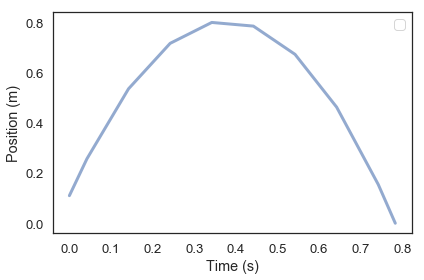

In [40]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

max_height = results.y.max()

print(force, max_height)

In [41]:
def sweep_force(force_array, params):
    sweep = SweepSeries()
    
    for force in force_array:
        
        system = make_system(Params(params, y_pos = y_pos, v_pos = v_pos, force = force))
        
        results, details = run_ode_solver(system, slope_func, 
                                          events=event_func,
                                          max_step=0.1*s)
        max_height = results.y.max()
        sweep[force.magnitude] = max_height
        
    return sweep


In [42]:
force_array = linspace(0.125, 2, 10) * N 
sweep = sweep_force(force_array, params);

C:\Miniconda3\lib\site-packages\pint\quantity.py:855: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = new_self._magnitude ** _to_magnitude(other, self.force_ndarray)
C:\Miniconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:140: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol


nan meter
nan meter / second


KeyboardInterrupt: 

In [ ]:
plot(sweep)
print(sweep)

decorate(xlabel='Force Applied (N)',
         ylabel='Max Height (m)',
         title='Force vs Max Height')

When the force applied by the frog jumping is equal to the buoyant force due to the water, then we know the lilypad has been submerged in water.

In [ ]:
# motion of lilypad

F_lily = - ρ * volume * g_a    # buoyant force
F_frog = force

print('Max Height: ', height)
print('Force of Frog: ', F_frog)
print('Buoyant Force: ', F_lily)

if F_frog >= F_lily: 
    print('Result: sink')
    new_area = (F_frog/(- ρ * y_init  * g_a))
    print('Old Lilypad Area: ', system.area)
    print('New Lilypad Area: ', new_area)
else: 
    print("Result: float")
    print('Old Lilypad Area: ', system.area)
    print('New Lilypad Area: ', system.area)


### Section 2: Extending to a 2-D jump

In [43]:
params1 = Params(params, velocity = system.v_pos, 
                 angle = 45 * degree, 
                 p_x = 0.01 * m,
                 p_y = 0.01 * m)

,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_0,0 second
t_end,30 second
t_mid,0.08 second
force,1 newton


In [44]:
# set up system values

# the frog is treated as point mass



def make_system1(params):

    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x_frog = p_x,
                 y_frog = p_y,
                 vx = vx,
                 vy = vy)
    
    # compute area from radius
    area = np.pi * r_lilypad **2
    
    return System(params, init=init, area=area)

In [45]:
system2 = make_system1(params1)

,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_0,0 second
t_end,30 second
t_mid,0.08 second
force,1 newton


In [46]:
def slope_func(state, t, system):

    p_x, p_y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)
    
    a_grav = Vector(0, g_a)

    return vx, vy, a_grav.x, a_grav.y

In [47]:

# we test it with the initial condition
slope_func(system2.init, 0, system2)

(<Quantity(2.6139051245215468, 'meter / second')>,
 <Quantity(2.6139051245215468, 'meter / second')>,
 <Quantity(0.0, 'meter / second ** 2')>,
 <Quantity(-9.8, 'meter / second ** 2')>)

In [48]:
def event_func(state, t, system):

    x_frog, y_frog, vx, vy = state
    return y_frog

In [49]:
results1, details = run_ode_solver(system2, slope_func, events=event_func, max_step=0.01*s)

In [50]:
details

,values
sol,None
t_events,[[0.5372486692128715]]
nfev,332
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


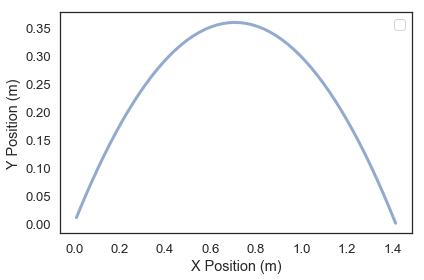

In [51]:
def plot_position(results):
    plot(results1.x_frog, results1.y_frog)
    decorate(xlabel='X Position (m)',
             ylabel='Y Position (m)')
    
plot_position(results1)

In [52]:
def range_func(angle, params):  

    params1 = Params(params, angle=angle)
    system1 = make_system1(params1)
    results1, details = run_ode_solver(system1, slope_func, events=event_func, max_step=0.01*s)
    height = max(results1.y_frog) * m
    return height

In [53]:
angles = linspace(20, 80, 21)
sweep1 = SweepSeries()

for angle in angles:
    height = range_func(angle, params)
    print(angle, height)
    sweep1[angle] = height

20.0 0.09150192122659341 meter
23.0 0.11642697023896359 meter
26.0 0.14397870383551248 meter
29.0 0.17382995837097243 meter
32.0 0.20569552243026384 meter
35.0 0.2393675574296331 meter
38.0 0.27420523762820664 meter
41.0 0.31006603038248676 meter
44.0 0.34636557351293124 meter
47.0 0.3829136636978859 meter
50.0 0.4190777390492246 meter
53.0 0.4545868724559999 meter
56.0 0.489140494125169 meter
59.0 0.5222260668728896 meter
62.0 0.5534959169338473 meter
65.0 0.5825992000765094 meter
68.0 0.6092760634157639 meter
71.0 0.6332904644517007 meter
74.0 0.6541770826830287 meter
77.0 0.6718969572854022 meter
80.0 0.6860841132312198 meter


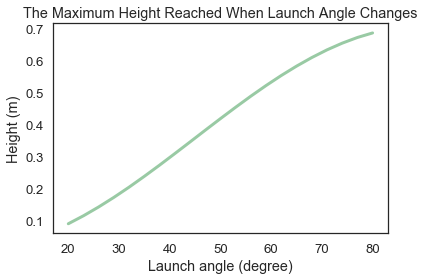

In [56]:
plot(sweep1, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Height (m)',
         title='The Maximum Height Reached When Launch Angle Changes',
         legend=False)

By comparing this graph to the one we generated in Force vs Max Height, we can find the relationship between the angle of frog jump and the force that is exerted on the lilypad, given a certian magnitude of velocity. 

## Results

## Interpretation